# Self-RAG

Self-reflection can enhance RAG, enabling correction of poor quality retrieval or generations.

Several recent papers focus on this theme, but implementing the ideas can be tricky.

Here we show how to implement ideas from the `Self RAG` paper [here](https://arxiv.org/abs/2310.11511) using LangGraph.

## Dependencies

Set `OPENAI_API_KEY`

## Self-RAG Detail

Self-RAG is a recent paper that introduces an interesting approach for self-reflective RAG. 

The framework trains an LLM (e.g., LLaMA2-7b or 13b) to generate tokens that govern the RAG process in a few ways:

1. Should I retrieve from retriever, `R` -

* Token: `Retrieve`
* Input: `x (question)` OR `x (question)`, `y (generation)`
* Decides when to retrieve `D` chunks with `R`
* Output: `yes, no, continue`

2. Are the retrieved passages `D` relevant to the question `x` -

* Token: `ISREL`
* * Input: (`x (question)`, `d (chunk)`) for `d` in `D`
* `d` provides useful information to solve `x`
* Output: `relevant, irrelevant`


3. Are the LLM generation from each chunk in `D` is relevant to the chunk (hallucinations, etc)  -

* Token: `ISSUP`
* Input: `x (question)`, `d (chunk)`,  `y (generation)` for `d` in `D`
* All of the verification-worthy statements in `y (generation)` are supported by `d`
* Output: `{fully supported, partially supported, no support`

4. The LLM generation from each chunk in `D` is a useful response to `x (question)` -

* Token: `ISUSE`
* Input: `x (question)`, `y (generation)` for `d` in `D`
* `y (generation)` is a useful response to `x (question)`.
* Output: `{5, 4, 3, 2, 1}`

We can represent this as a graph:

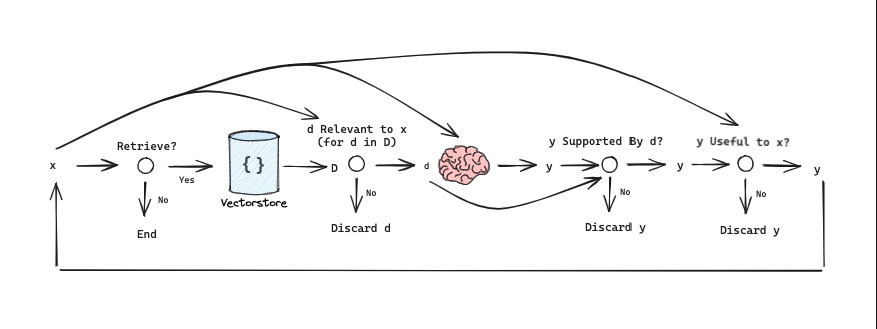

---

Let's implement some of these ideas from scratch using [LangGraph](https://js.langchain.com/docs/langgraph).

## Setup

### Load env vars

Add a `.env` variable in the root of the `./examples` folder with your variables.

In [1]:
import { load } from "https://deno.land/std@0.215.0/dotenv/mod.ts";

const env = await load({ envPath: "../.env" });
Object.entries(env).forEach(([key, value]) => Deno.env.set(key, value));

### Install dependencies

```bash
npm install cheerio chroma zod langchain @langchain/community @langchain/openai @langchain/core
```

In [2]:
import "cheerio";
import "chromadb";
import { CheerioWebBaseLoader } from "langchain/document_loaders/web/cheerio";
import { RecursiveCharacterTextSplitter } from "langchain/text_splitter";
import { Chroma } from "@langchain/community/vectorstores/chroma";
import { OpenAIEmbeddings } from "@langchain/openai"; 

const urls = [
  "https://lilianweng.github.io/posts/2023-06-23-agent/",
  "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
  "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
];

const docs = await Promise.all(urls.map((url) => new CheerioWebBaseLoader(url).load()));
const docsList = docs.flat();

const textSplitter = new RecursiveCharacterTextSplitter({ chunkSize: 100, chunkOverlap: 50 });
const docSplits = await textSplitter.splitDocuments(docsList);

// Add to vectorDB
const vectorStore = await Chroma.fromDocuments(docSplits, new OpenAIEmbeddings(), {
  collectionName: "self-rag-chroma",
});
const retriever = vectorStore.asRetriever();

[Module: null prototype] {
  AdminClient: [class AdminClient],
  ChromaClient: [class ChromaClient],
  CloudClient: [class CloudClient extends ChromaClient],
  CohereEmbeddingFunction: [class CohereEmbeddingFunction],
  Collection: [class Collection],
  DefaultEmbeddingFunction: [class _DefaultEmbeddingFunction],
  GoogleGenerativeAiEmbeddingFunction: [class _GoogleGenerativeAiEmbeddingFunction],
  HuggingFaceEmbeddingServerFunction: [class HuggingFaceEmbeddingServerFunction],
  IncludeEnum: {
    Documents: "documents",
    Embeddings: "embeddings",
    Metadatas: "metadatas",
    Distances: "distances"
  },
  JinaEmbeddingFunction: [class JinaEmbeddingFunction],
  OpenAIEmbeddingFunction: [class _OpenAIEmbeddingFunction],
  TransformersEmbeddingFunction: [class _TransformersEmbeddingFunction]
}

## State
 
We will define a graph.

Our state will be an `object`.

We can access this from any graph node as `state.key`.

In [15]:
/**
 * Represents the state of our graph.
 */
type GraphState = {
  /**
   * An object where each key is a string.
   */
  keys: Record<string, any>;
}

const graphState = {
  keys: {
    value: null,
    default: () => ({}),
  }
}

## Nodes and Edges

Each `node` will simply modify the `state`.

Each `edge` will choose which `node` to call next.

We can lay out `self-RAG` as a graph.

Here is our graph flow:

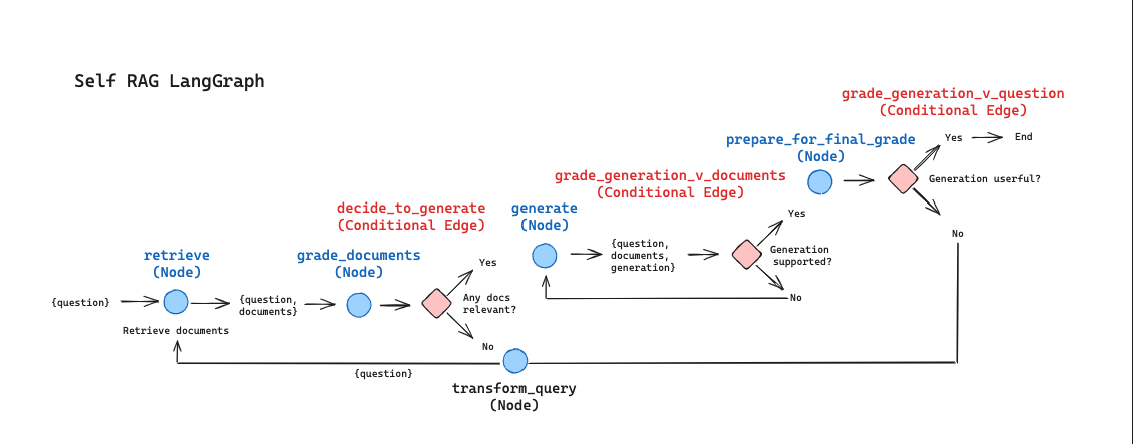

In [29]:
import { StructuredTool } from "@langchain/core/tools";
import { RunnableConfig } from "@langchain/core/runnables";
import { DocumentInterface } from "@langchain/core/documents";
import { z } from "zod";
import { ChatPromptTemplate } from "@langchain/core/prompts";
import { pull } from "langchain/hub";
import { ChatOpenAI } from "@langchain/openai";
import { StringOutputParser } from "@langchain/core/output_parsers";
import { convertToOpenAITool } from "@langchain/core/utils/function_calling";
import { JsonOutputToolsParser } from "langchain/output_parsers";

// Data model (create via a LangChain tool)
const zodScore = z.object({
  binaryScore: z.enum(["yes", "no"]).describe("Relevance score 'yes' or 'no'"),
});
class Grade extends StructuredTool<typeof zodScore> {
  name = "grade";
  description = "Grade the relevance of the retrieved documents to the question. Either 'yes' or 'no'.";
  schema = zodScore
  async _call(input: z.infer<typeof this["schema"]>) {
    return JSON.stringify(input);
  }
}
const gradeToolOai = convertToOpenAITool(new Grade());

/**
 * Retrieve documents
 * 
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function retrieve(state: GraphState, config?: RunnableConfig) {
  console.log("---RETRIEVE---");
  const stateObject = state.keys;
  const question = stateObject.question;
  const documents = await retriever.getRelevantDocuments(question, config);
  return {
    keys: {
      documents,
      question,
    }
  }
};

/**
 * Generate answer
 * 
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function generate(state: GraphState, config?: RunnableConfig) {
  console.log("---GENERATE---");
  const stateObject = state.keys;
  const documents = stateObject.documents;
  const question = stateObject.question;
  
  // Pull in the prompt
  const prompt = await pull<ChatPromptTemplate>("rlm/rag-prompt");

  // LLM
  const llm = new ChatOpenAI({
    modelName: "gpt-3.5-turbo",
    temperature: 0,
  });

  // RAG Chain
  const ragChain = prompt.pipe(llm).pipe(new StringOutputParser());

  const formattedDocs = documents.map((doc) => doc.pageContent).join("\n\n");

  const generation = await ragChain.invoke({ context: formattedDocs, question }, config);

  return {
    keys: {
      documents,
      question,
      generation,
    }
  }
}

/**
 * Determines whether the retrieved documents are relevant to the question.
 * 
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function gradeDocuments(state: GraphState, config?: RunnableConfig) {
  console.log("---CHECK RELEVANCE---");
  const stateObject = state.keys;
  const documents = stateObject.documents;
  const question = stateObject.question;

  const model = new ChatOpenAI({
    modelName: "gpt-4-0125-preview",
    temperature: 0,
  });

  const parser = new JsonOutputToolsParser();

  // LLM with tool and enforce invocation
  const llmWithTool = model.bind({
    tools: [gradeToolOai],
    tool_choice: gradeToolOai,
  });

  const prompt = ChatPromptTemplate.fromTemplate(`You are a grader assessing relevance of a retrieved document to a user question.
  Here is the retrieved document:
  
  {context}
  
  Here is the user question: {question}

  If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
  Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.`);

  // Chain
  const chain = prompt.pipe(llmWithTool).pipe(parser);

  const filteredDocs: Array<DocumentInterface> = [];
  for await (const doc of documents) {
    const grade = await chain.invoke({ context: doc.pageContent, question }, config);
    const { args } = grade[0];
    if (args.binaryScore === "yes") {
      console.log("---GRADE: DOCUMENT RELEVANT---")
      filteredDocs.push(doc);
    } else {
      console.log("---GRADE: DOCUMENT NOT RELEVANT---")
    }
  }

  return {
    keys: {
      documents: filteredDocs,
      question,
    }
  }
}

/**
 * Transform the query to produce a better question.
 * 
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function transformQuery(state: GraphState, config?: RunnableConfig) {
  console.log("---TRANSFORM QUERY---");
  const stateObject = state.keys;
  const question = stateObject.question;
  const documents = stateObject.documents;

  // Pull in the prompt
  const prompt = ChatPromptTemplate.fromTemplate(`You are generating a question that is well optimized for semantic search retrieval.
  Look at the input and try to reason about the underlying sematic intent / meaning.
  Here is the initial question:
  \n ------- \n
  {question} 
  \n ------- \n
  Formulate an improved question: `)

  // Grader
  const model = new ChatOpenAI({
    modelName: "gpt-4-0125-preview",
    temperature: 0,
    streaming: true,
  });

  // Prompt
  const chain = prompt.pipe(model).pipe(new StringOutputParser())
  const betterQuestion = await chain.invoke({ question }, config);

  return {
    keys: {
      question: betterQuestion,
      documents,
    }
  }
}

/**
 * Passthrough state for final grade.
 * 
 * @param {GraphState} state The current state of the graph.
 * @returns {Promise<GraphState>} The new state object.
 */
function prepareForFinalGrade(state: GraphState) {
  console.log("---FINAL GRADE---");
  const stateObject = state.keys;
  const question = stateObject.question;
  const documents = stateObject.documents;
  const generation = stateObject.generation;

  return {
    keys: {
      documents,
      question,
      generation,
    }
  }
}

/**
 * Determines whether to generate an answer, or re-generate a question.
 * 
 * @param {GraphState} state The current state of the graph.
 * @returns {"transformQuery" | "generate"} Next node to call
 */
function decideToGenerate(state: GraphState) {
  console.log("---DECIDE TO GENERATE---");
  const stateObject = state.keys;
  const filteredDocs = stateObject.documents;

  if (filteredDocs.length === 0) {
    // All documents have been filtered checkRelevance
    // We will re-generate a new query
    console.log("---DECISION: TRANSFORM QUERY---");
    return "transformQuery";
  }
  // We have relevant documents, so generate answer
  console.log("---DECISION: GENERATE---");
  return "generate";
};

/**
 * Determines whether the generation is grounded in the document.
 * 
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function generateGenerationVDocumentsGrade(state: GraphState, config?: RunnableConfig) {
  console.log("---GENERATE GENERATION vs DOCUMENTS GRADE---");
  const stateObject = state.keys;
  const documents = stateObject.documents;
  const generation = stateObject.generation;

  const model = new ChatOpenAI({
    modelName: "gpt-4-0125-preview",
    temperature: 0,
  });
  // LLM with tool and enforce invocation
  const llmWithTool = model.bind({
    tools: [gradeToolOai],
    tool_choice: gradeToolOai,
  });
  const parser = new JsonOutputToolsParser();

  const prompt = ChatPromptTemplate.fromTemplate(`You are a grader assessing whether an answer is grounded in / supported by a set of facts.
  Here are the facts:
  \n ------- \n
  {documents} 
  \n ------- \n
  Here is the answer: {generation}
  Give a binary score 'yes' or 'no' to indicate whether the answer is grounded in / supported by a set of facts.`);

  const chain = prompt.pipe(llmWithTool).pipe(parser);

  const formattedDocs = documents.map((doc) => doc.pageContent).join("\n\n");

  const score = await chain.invoke({ documents: formattedDocs, generation }, config);
  const grade = score[0].args.binaryScore;

  return {
    keys: {
      ...stateObject,
      generationVDocumentsGrade: grade,
    }
  }
};

function gradeGenerationVDocuments(state: GraphState) {
  console.log("---GRADE GENERATION vs DOCUMENTS---");

  const stateObject = state.keys;
  const grade = stateObject.generationVDocumentsGrade;

  if (grade === "yes") {
    console.log("---DECISION: SUPPORTED, MOVE TO FINAL GRADE---");
    return "supported";
  }
  console.log("---DECISION: NOT SUPPORTED, GENERATE AGAIN---")
  return "not supported";
}

/**
 * Determines whether the generation addresses the question.
 * 
 * @param {GraphState} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<GraphState>} The new state object.
 */
async function generateGenerationVQuestionGrade(state: GraphState, config?: RunnableConfig) {
  console.log("---GENERATE GENERATION vs QUESTION GRADE---");
  const stateObject = state.keys;
  const question = stateObject.question;
  const generation = stateObject.generation;

  const model = new ChatOpenAI({
    modelName: "gpt-4-0125-preview",
    temperature: 0,
  });
  // LLM with tool and enforce invocation
  const llmWithTool = model.bind({
    tools: [gradeToolOai],
    tool_choice: gradeToolOai,
  });
  const parser = new JsonOutputToolsParser();

  const prompt = ChatPromptTemplate.fromTemplate(`You are a grader assessing whether an answer is useful to resolve a question.
  Here is the answer:
  \n ------- \n
  {generation} 
  \n ------- \n
  Here is the question: {question}
  Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question.`);

  const chain = prompt.pipe(llmWithTool).pipe(parser);

  const score = await chain.invoke({ question, generation }, config);
  const grade = score[0].args.binaryScore;

  return {
    keys: {
      ...stateObject,
      generationVQuestionGrade: grade,
    }
  }
};

function gradeGenerationVQuestion(state: GraphState) {
  console.log("---GRADE GENERATION vs QUESTION---");

  const stateObject = state.keys;
  const grade = stateObject.generationVQuestionGrade;

  if (grade === "yes") {
    console.log("---DECISION: USEFUL---")
    return "useful"
  }
  console.log("---DECISION: NOT USEFUL---")
  return "not useful"
}

## Build Graph

The just follows the flow we outlined in the figure above.

In [30]:
import { StateGraph, END } from "@langchain/langgraph";

const workflow = new StateGraph<GraphState>({
  channels: graphState
});

// Define the nodes
workflow.addNode("retrieve", retrieve);
workflow.addNode("gradeDocuments", gradeDocuments);
workflow.addNode("generate", generate)
workflow.addNode("generateGenerationVDocumentsGrade", generateGenerationVDocumentsGrade);
workflow.addNode("transformQuery", transformQuery);
workflow.addNode("prepareForFinalGrade", prepareForFinalGrade);
workflow.addNode("generateGenerationVQuestionGrade", generateGenerationVQuestionGrade);

// Build graph
workflow.setEntryPoint("retrieve");
workflow.addEdge("retrieve", "gradeDocuments");
workflow.addConditionalEdges(
  "gradeDocuments",
  decideToGenerate,
  {
    "transformQuery": "transformQuery",
    "generate": "generate"
  }
);
workflow.addEdge("transformQuery", "retrieve");
workflow.addEdge("generate", "generateGenerationVDocumentsGrade");
workflow.addConditionalEdges(
  "generateGenerationVDocumentsGrade",
  gradeGenerationVDocuments,
  {
    "supported": "prepareForFinalGrade",
    "not supported": "generate"
  }
);

workflow.addEdge("prepareForFinalGrade", "generateGenerationVQuestionGrade");
workflow.addConditionalEdges(
  "generateGenerationVQuestionGrade",
  gradeGenerationVQuestion,
  {
    "useful": END,
    "not useful": "transformQuery"
  }
);

// Compile
const app = workflow.compile();

## Run the graph

In [32]:
const inputs = { keys: { question: "Explain how the different types of agent memory work." }};
const config = { recursionLimit: 50 };
let finalGeneration;
for await (const output of await app.stream(inputs, config)) {
  for (const [key, value] of Object.entries(output)) {
    console.log(`Node: '${key}'`);
    // Optional: log full state at each node
    // console.log(JSON.stringify(value, null, 2));
    finalGeneration = value;
  }
  console.log("\n---\n");
}

// Log the final generation.
console.log(JSON.stringify(finalGeneration, null, 2));

---RETRIEVE---
{
  keys: { question: "Explain how the different types of agent memory work." }
}
Node: 'retrieve'

---

---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
Node: 'gradeDocuments'

---

---DECIDE TO GENERATE---
---DECISION: GENERATE---
---GENERATE---
Node: 'generate'

---

---GENERATE GENERATION vs DOCUMENTS GRADE---
FROM GENERATION { binaryScore: "yes" }
Node: 'generateGenerationVDocumentsGrade'

---

---GRADE GENERATION vs DOCUMENTS---
GRADE yes
---DECISION: SUPPORTED, MOVE TO FINAL GRADE---
---FINAL GRADE---
Node: 'prepareForFinalGrade'

---

---GENERATE GENERATION vs QUESTION GRADE---
Node: 'generateGenerationVQuestionGrade'

---

---GRADE GENERATION vs QUESTION---
---DECISION: USEFUL---
Node: '__end__'

---

{
  "keys": {
    "documents": [
      {
        "pageContent": "Types of Memory",
        "metadata": {
          "source": "https://lilianweng.github.io/posts

> #### See the LangSmith trace [here](https://smith.langchain.com/public/c7a7c4b7-5b3f-4a78-ae59-9e3492d5a8d9/r).